# Elevator Telemetrics

The following function connects to the Cloudant database containing the telemetrics 

In [2]:
#Please don't modify this function
def readDataFrameFromCloudant(host,user,pw,database):
    cloudantdata=spark.read.format("com.cloudant.spark"). \
    option("cloudant.host",host). \
    option("cloudant.username", user). \
    option("cloudant.password", pw). \
    load(database)

    cloudantdata.createOrReplaceTempView("elevator_telemetrics")
    spark.sql("SELECT * from elevator_telemetrics").show()
    return cloudantdata

The following piece of code connects to the database and returns a RDD data frame for the telemetrics data.

In [3]:
#TODO Please provide your Cloudant credentials here
hostname = "<your hostname here>"
user = "<your user name here>"
pw = "<your password here>"
database = "<your database name here>"

cloudantdata=readDataFrameFromCloudant(hostname, user, pw, database)

+--------------------+--------------------+--------------------+----------+----------+---------+------+--------------------+
|                 _id|                _rev|                data|  deviceId|deviceType|eventType|format|           timestamp|
+--------------------+--------------------+--------------------+----------+----------+---------+------+--------------------+
|001115e0-d67b-11e...|1-214078186ec43f1...|[[0.0,89,1,2.0,0....|Elevator01|  Elevator|   Status|  json|2017-01-09T14:50:...|
|00116400-d67b-11e...|1-e9bd62a041e192d...|[[0.0,87,1,0.0,0....|Elevator02|  Elevator|   Status|  json|2017-01-09T14:50:...|
|00116401-d67b-11e...|1-84f36dd2939fc6c...|[[14.0,78,1,4.0,0...|Elevator04|  Elevator|   Status|  json|2017-01-09T14:50:...|
|00116401-d67b-11e...|1-1afc4a14b25a8ab...|[[4.0,72,1,2.0,0....|Elevator05|  Elevator|   Status|  json|2017-01-09T14:50:...|
|00116401-d67b-11e...|1-248ef40a0e0e743...|[[0.0,76,1,0.0,0....|Elevator03|  Elevator|   Status|  json|2017-01-09T14:50:...|


The next cells prepare the data for analysis:
1) The data is extracted using a sample factor of 0.5 (50%). 
2) The map function selects the timestamp, the deviceId and the motor temperature. 
3) The sorted function sorts the data by the first element in the tuple (the timestamp)
4) The filter function removes columns where the temperature is absent (None)

In [4]:
sampling_factor = 0.5

def getData(df,spark):
    etm = sorted(df.rdd.sample(False,sampling_factor).map(lambda row : (row.timestamp[:19],row.deviceId,row.data.d.motorTemp)).collect(), key = lambda data : data[0])
    return filter(lambda (ts,dev,temp) : (not temp is None) and (not ts is None),etm)

In [5]:
elevator_telemetrics = getData(cloudantdata,spark)

The next group of cells prepare the data for printing a history diagram using matplotlib
1) The matplotlib library is imported
2) The map function returns a list of the temperatures
3) The history diagram is printed

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
elevator_temp = map (lambda (ts,dev,temp) : int(temp), filter(lambda (ts,dev,temp) : True,elevator_telemetrics)) 

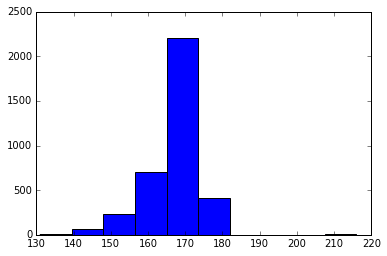

In [8]:
plt.hist(elevator_temp)
plt.show()

The next cell generates a matplot box diagram showing the mean value, the standard deviation, the outlier boundary and the outliers.

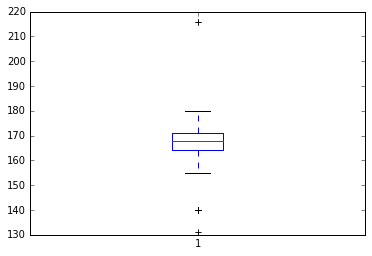

In [9]:
plt.boxplot(elevator_temp)
plt.show()

The next cell prepare the data for a matplotlib runchart which is ideal to show time series. The plot function requires for a list of time stamps as well as a list of temperatures.
For the temperatures we can reuse elevator_temp that was computed earlier. For the list of timestamps the date is converted to a timestamp before the diagram is printed.

In [10]:
import time
import datetime

#myDate = "2014-08-01 04:41:52,117"
#timestamp = time.mktime(datetime.datetime.strptime(myDate, "%Y-%m-%d %H:%M:%S,%f").timetuple())

elevator_ts = map (lambda (date,dev,temp) : time.mktime(datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").timetuple()), filter(lambda (ts,dev,temp) : not ts is None,elevator_telemetrics))

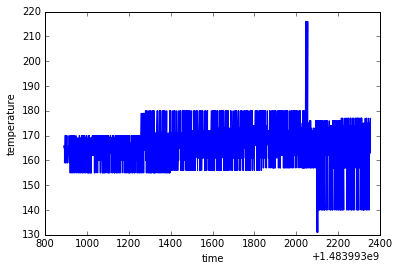

In [11]:
plt.plot(elevator_ts,elevator_temp)
plt.xlabel("time")
plt.ylabel("temperature")
plt.show()

This ends our initial investigation of the elevator telemetrics. The following observations can be made:
1) The histogram informs us that the skew is negative which is to be expected.
2) The boxplot tells us that the temperature of the engines is usually in the 160-180 area with some outlayers
3) The time series diagram show the distribution over time and the point in time where the temperature deviates from the normal.